In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BERT Fine-Tuning
(sources: <a href="https://huggingface.co/docs/transformers/training#finetune-a-pretrained-model">Fine-tune a Pre-Trained Model</a>, <a href="https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/BERT_Fine_Tuning.ipynb#scrollTo=xlQG7qgkmf4n">BERT Sentence Classification</a>)

Fine-tuning a pre-trained model like BERT for specific NLP tasks can be more advantageous than building your own model from scratch due to several reasons:

- **Efficient Training**: The pre-trained BERT model already encodes substantial information about language, hence fine-tuning requires less training time. You're basically tweaking an already trained model for your specific task.

- **Data Efficiency**: Fine-tuning allows achieving good results with less data than would be required for training a model from scratch. This can save considerable time and resources, which would otherwise be invested in creating a large dataset.

- **Superior Results**: The fine-tuning approach has proven to deliver state-of-the-art results for a wide range of tasks with minimal task-specific adjustments. It's a powerful alternative to implementing complex, custom architectures.

- **Parallels with Computer Vision**: This shift towards transfer learning in NLP is similar to the trend observed in computer vision a few years back. It's become common to leverage pre-trained models and fine-tune them for new tasks instead of training expensive networks from scratch.

In summary, leveraging pre-trained models such as BERT for specific NLP tasks can provide effective results, save time and resources, and require less data compared to building a model from scratch.


In [2]:
!pip install pytorch-pretrained-bert
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.9 MB/s eta 0:00:00


In [3]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.9 MB/s eta 0:00:00


Note: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [4]:
!pip install accelerate -U

In [5]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Libraries

In [1]:
from IPython.display import Image
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate
from sklearn.metrics import matthews_corrcoef

import torch
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification # HuggingFace open-source library of generic model class
from transformers import TrainingArguments, Trainer # Training Hyperparameter

To enable PyTorch to use the GPU, we must first designate the GPU as the device. Afterwards, during our training process, we'll make sure to load the data onto this specified device.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

## Dataset

We will be utilizing The Corpus of Linguistic Acceptability (CoLA) for the task of single-sentence classification. This compilation consists of various sentences that have been marked as either grammatically correct or incorrect. The dataset includes the following attributes:

- **First Column**: A code denoting the origin or source of the given sentence.
- **Second Column**: A binary label indicating the acceptability judgment (0 signifies unacceptable, 1 denotes acceptable).
- **Third Column**: The original acceptability judgment as annotated by the creator.
- **Fourth Column**: The actual sentence.

You can acquire this dataset from the following [link](https://nyu-mll.github.io/CoLA/), and make sure to download the raw version of the data. The raw version is preferred as we need to process the text using BERT's tokenizer, transforming the sentences into tokens and segments that the model can interpret. Move the downloaded files to a suitable location on your local drive for further use.

In [8]:
# Upload the train file from your local drive
uploaded = files.upload()

Saving in_domain_train.tsv to in_domain_train.tsv


In [3]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [4]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [11]:
df.label.unique()

array([1, 0])

In [12]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

### Tokenize Dataset

The specific formatting that BERT demands for input in sentence classification tasks includes the following elements:

- **input ids**: A sequence of integers where each number represents the position of a token within the BERT tokenizer vocabulary.
- **segment mask**: An optional sequence made up of 1s and 0s, used to distinguish whether the input includes one sentence or two. A single-sentence input will have a sequence entirely of 0s, whereas a two-sentence input will feature a 0 for each token of the first sentence and a 1 for each token of the second.
- **attention mask**: This optional binary sequence has 1s that align with input tokens and 0s that align with padding tokens.
- **labels**: A single value, between 0 and 1.

Use BERT tokenizer to transform text sentences into tokens. We load the pretrained BERT tokenizer. This tokenizer has been trained on the 'bert-base-uncased' model and converts all text to lowercase using a list comprehension. The `tokenizer.tokenize` function is applied to every sentence in the list.

Please note that the variable 'sentences' should be defined as a list of sentences that you want to tokenize. Without this context, the current code snippet might not work as expected.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 919351.08B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [14]:
lengths = [len(sent) for sent in tokenized_texts]
print(max(lengths))

47


###  Padding and Truncation

The BERT model necessitates that all input sequences are of equivalent length. To accomplish this, we select a maximum length (`MAX_LEN`) for our sentences and adjust all inputs to match this length through the process of padding and truncating.

Padding is used when a sentence is shorter than the maximum length - we add 0s to the sequence until it reaches the desired length.

On the other hand, truncation is used when a sentence surpasses the maximum length. In this case, we discard the extra elements at the end of the sequence until it conforms to our predetermined maximum length.

We implement the 'post' strategy for both padding and truncation, which means these operations are performed at the end of the sequence rather than at the beginning. The function `pad_sequences` from Keras is a convenient tool that simplifies this process of adjusting Python lists.

In [15]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [16]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [17]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

### Attention Mask


Attention masks are a crucial part of many transformer-based models, including BERT. In these models, attention masks are used to distinguish the actual content of the input from the padding that's added to ensure that all sequences in a batch have the same length.

In the context below[link text](https://), the attention mask is a sequence of binary values corresponding to the input sequence. A value of 1 in the attention mask indicates that the corresponding token in the input sequence is meaningful content, while a value of 0 signifies a padding token. During the attention computation, the mask ensures that padding tokens do not contribute to the result, effectively "masking" them out. This allows the model to focus solely on the meaningful parts of the input, ignoring the padding.

In [18]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

### Split Dataset into train and val set

In [20]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [21]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Dataloader

Create a DataLoader for your training and test datasets so you can iterate over batches of data:

In [22]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [23]:
# Check the shape of the first tensor in the dataset
for data in train_dataloader:
  print(data[0].shape)
  print(data[1].shape)
  break

torch.Size([16, 128])
torch.Size([16, 128])


## Train Model

We're going to tailor the pre-trained BERT model to our task by fine-tuning it. The first step involves altering the BERT model to output results suitable for classification. We'll then continue to train the model on our dataset until it's entirely equipped for our task. Thankfully, Huggingface's PyTorch implementation has a collection of interfaces designed for various NLP tasks. Each interface is built on a pre-trained BERT model, but they all have unique top layers and output types designed to fit their respective NLP task.

We'll use [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). It's the standard BERT model, augmented with an extra single linear layer for classification purposes. The entire pre-trained BERT model, along with the additional untrained classification layer, will be trained on our specific task as we input data.

### The Structure of the Fine-Tuned Model

The first token in every sequence is the special classification token ([CLS]). This token's corresponding hidden state is a comprehensive representation of the whole sentence and is used for classification tasks, as per BERT's authors. So, when we train the model using an input sentence, the output is the hidden state vector (length 768) associated with this token. We've added an additional layer that includes untrained linear neurons of size [hidden_state, number_of_labels], or [768,2]. This means the output of BERT, combined with our classification layer, is a two-number vector representing the "score" for "grammatical/non-grammatical," which is then processed through cross-entropy loss.

### Fine-Tuning Procedure

Fine-tuning the classifier is quite efficient since the pre-trained BERT layers already contain a significant amount of language information. Instead of training each layer in a large model from scratch, it's as if the lower layers are already 95% trained, and we only need to focus on the top layer, with minor adjustments to the lower layers for our task.

Sometimes, practitioners may choose to "freeze" certain layers during fine-tuning or apply different or diminishing learning rates to preserve the high-quality weights in the network and speed up training. Recent research on BERT suggests that freezing most of the weights results in minimal accuracy losses. However, there are exceptions, and the broader principles of transfer learning should be considered. If your task and fine-tuning dataset significantly differ from the dataset used to train the transfer learning model, freezing weights might not be advisable. We'll explore the broader aspects of transfer learning in NLP in an upcoming article.

There are a few different pre-trained BERT models available. We will use "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").


In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
)

model.cuda()

100%|██████████| 407873900/407873900 [00:13<00:00, 30212766.23B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [25]:
params = list(model.named_parameters())

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNor

In [26]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 109,483,778 trainable parameters


### Hyperparameters

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We will set up the parameters for the optimizer in a way that applies different weight decay rates to different parts of the model. Specifically, it divides the model's parameters into two groups: one that includes the bias, gamma, and beta parameters, and another that includes the remaining parameters. For the group containing bias, gamma, and beta, the weight decay rate is set to 0.0, meaning that no weight decay will be applied to these parameters during training. For the other group, the weight decay rate is set to 0.01, so these parameters will be subject to weight decay. This differentiation allows for more nuanced control over regularization during the training process, and it's a common practice to exclude bias and normalization parameters from weight decay to maintain the training stability.

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [28]:
# This variable contains all of the hyperparemeter information our training loop needs
num_train_epochs = 3

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1,
                     eps = 1e-8,) # args.adam_epsilon  - default is 1e-8.
                    #  t_total=t_total)


In [29]:
t_total = len(train_dataloader) * num_train_epochs
print("Total steps: ", t_total)

Total steps:  1443


### Training Loop

Our training process consists of a training loop and an evaluation loop, each with distinct tasks. For every iteration, we perform the following steps:

Training loop:
- Switch the model into training mode to enable gradient computation
- Extract our input data and corresponding labels
- Transfer the data onto the GPU for faster processing
- Reset the gradients accumulated from the previous iteration (since PyTorch, by default, accumulates gradients which is beneficial for constructs like RNNs)
- Perform a forward pass, i.e., pass the input data through the model
- Execute a backward pass for backpropagation
- Update the model parameters using `optimizer.step()`
- Monitor and record progress-related variables

Evaluation loop:
- Switch the model into evaluation mode to prevent gradient computation
- Extract our input data and corresponding labels
- Transfer the data onto the GPU for faster processing
- Perform a forward pass, i.e., pass the input data through the model
- Calculate loss on our validation dataset and record progress-related variables

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5193740929207782


Epoch:  25%|██▌       | 1/4 [01:43<05:10, 103.55s/it]

Validation Accuracy: 0.7974537037037037
Train loss: 0.2665280693030593


Epoch:  50%|█████     | 2/4 [03:24<03:23, 101.88s/it]

Validation Accuracy: 0.8229166666666666
Train loss: 0.11653551463910965


Epoch:  75%|███████▌  | 3/4 [05:04<01:41, 101.23s/it]

Validation Accuracy: 0.8321759259259259
Train loss: 0.06784857700122889


Epoch: 100%|██████████| 4/4 [06:46<00:00, 101.64s/it]

Validation Accuracy: 0.8240740740740741


## Training Evaluation

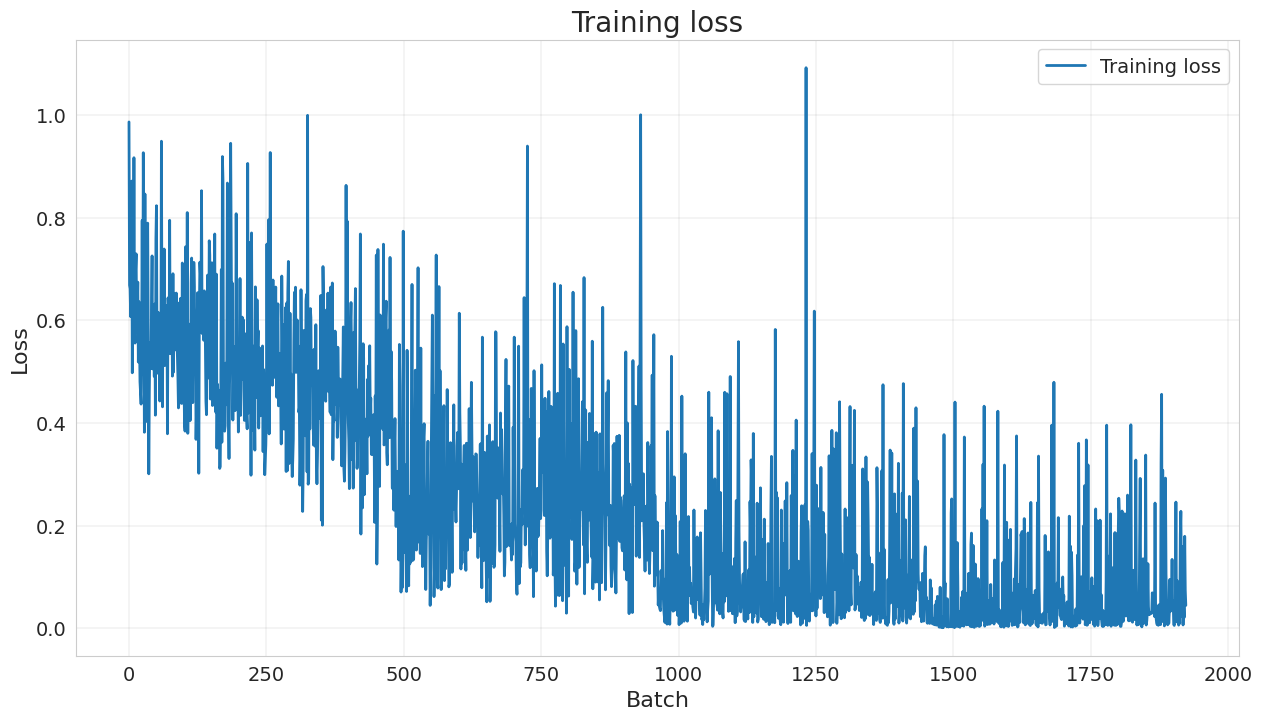

In [36]:
plt.figure(figsize=(15,8))
plt.title("Training loss", fontsize=20)
plt.xlabel("Batch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.plot(train_loss_set, linewidth=2, markersize=5, label="Training loss")
plt.legend(fontsize=14)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
sns.set_style("whitegrid")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


## Hold-Out Set

Next, we will turn our attention to the holdout dataset, processing and preparing the inputs in the same manner we applied to the training set. For the evaluation of our predictions, we will use [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html). This choice of metric aligns with the common practice within the NLP community for gauging performance on the CoLA task. With Matthew's correlation coefficient, a score of +1 represents the best performance, while -1 indicates the worst. By using this measure, we can directly compare our model's performance to the existing state-of-the-art solutions for this particular challenge.

In [37]:
# Upload the test file from your local drive
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [38]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 16


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [39]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [41]:
# Import and evaluate each test batch using Matthew's correlation coefficient
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [42]:
matthews_set

[0.0,
 -0.17407765595569785,
 -0.18156825980064073,
 -0.3333333333333333,
 -0.29277002188455997,
 0.8783100656536799,
 0.5606119105813882,
 -0.0778498944161523,
 0.0,
 0.7125253031944253,
 0.6180700462007377,
 0.7453559924999299,
 0.3333333333333333,
 0.6201736729460423,
 0.4472135954999579,
 0.0,
 0.8320502943378436,
 0.8563488385776753,
 0.4236592728681617,
 0.6201736729460423,
 0.7090909090909091,
 0.8320502943378436,
 0.8703882797784892,
 0.7867957924694432,
 0.5945883900105632,
 0.6546536707079772,
 1.0,
 0.6666666666666666,
 0.5897435897435898,
 0.6201736729460423,
 0.42289003161103106,
 0.7867957924694432,
 0.0]

In [43]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [44]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.4869603726031367

## Conclusion

This post demonstrate that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Train with PyTorch Trainer

In [78]:
# del model
# del trainer
# del tokenizer
# torch.cuda.empty_cache()


<h3>PyTorch Trainer</h3>

The <a href="https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.Trainer">`Trainer`</a> class within Transformers simplifies the training process by offering an optimized environment for these specific models. It supports an array of features including logging, gradient accumulation, and mixed precision, eliminating the need for a manually written training loop.

- load our model
- specify expected labels = 5 (as per Yelp Review dataset <a href="https://huggingface.co/datasets/yelp_review_full#data-fields">card<a>)

As we are using the Hugging Face Transformers library, we will use the Dataset class from the datasets library to handle the tokenized datasets and the split between training and validation.

Tokenize your dataset and store in DataFrame:

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(example):
    return tokenizer(example['sentence'], padding="max_length", truncation=True)

tokenized_data = df.apply(tokenize_function, axis=1)
labels = df['label'].tolist()



Split the dataset:

In [6]:
train_data, val_data, train_labels, val_labels = train_test_split(tokenized_data, labels, test_size=0.1)

Convert the DataFrame into a Dataset object:

In [7]:
train_set = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [item['input_ids'] for item in train_data],
    'attention_mask': [item['attention_mask'] for item in train_data],
    'label': train_labels
}))
val_set = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [item['input_ids'] for item in val_data],
    'attention_mask': [item['attention_mask'] for item in val_data],
    'label': val_labels
}))

In [8]:
train_set, val_set

(Dataset({
     features: ['input_ids', 'attention_mask', 'label'],
     num_rows: 7695
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'label'],
     num_rows: 856
 }))

In [9]:
# <https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# The pretrained head of the BERT model is discarded, and replaced with a randomly initialized
# classification head. You will fine-tune this new model head on your sequence classification task,
# transferring the knowledge of the pretrained model to it.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

<h3>HyperParameters</h3>

Next, we need to establish a <a href="https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.TrainingArguments">`TrainingArguments`</a> class. This class houses all the tunable hyperparameters and flags we can use to adjust various training options. For this particular guide, we'll kick things off with the default training hyperparameters. However, don't hesitate to play with these to uncover the settings that best suit your requirements.

Here are some commonly used hyperparameters for beginners:

1. `learning_rate`: This is how fast your model learns. A smaller value like 1e-5 means slow learning, and a larger value like 0.01 means fast learning. A commonly used starting point is 2e-5.

2. `num_train_epochs`: This is how many times the model goes through the entire training dataset. A common starting point is 3.

3. `per_device_train_batch_size`: This is how many samples to process at once per device during training. It depends on the memory of your device, but a common starting point is 16 for GPUs and 8 or less for CPUs.

4. `per_device_eval_batch_size`: This is similar to the training batch size but for the evaluation phase. A common starting point is 64.

5. `warmup_steps`: This is the number of steps the learning rate will increase before it starts decreasing. It's usually a fraction of the total training steps (`num_train_epochs` * size of the training dataset / `per_device_train_batch_size`). A common starting point is 0.

6. `weight_decay`: This is a regularization technique. When it is not zero, the weights decrease a bit at each step, preventing them from growing too large. A common starting point is 0.01.

Remember, hyperparameters are not one-size-fits-all, and they might need to be adjusted based on your specific task, data, and requirements. A good practice is to start with these common settings and then tweak based on the performance of your model.

NOTE: In case we're interested in tracking our evaluation metrics throughout the fine-tuning process, we can set the `evaluation_strategy` parameter in our training arguments. This will provide a report of the evaluation metric after each training epoch.

In [11]:
training_args = TrainingArguments(output_dir="test_trainer")

<h3>Evaluate</h3>

The <a href="https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.Trainer">`Trainer`</a> class doesn't inherently assess the model's performance during the training phase. Therefore, you have to supply a function to the Trainer which can compute and present the metrics. You can utilize the function provided by the <a href="https://huggingface.co/docs/evaluate/index">`Evaluate`</a> library, which is simple and measures accuracy. This function can be loaded using 'evaluate.load'. Refer to the quicktour for a more detailed explanation.

In [12]:
metric = evaluate.load("accuracy")

To compute the accuracy of your model's predictions, we use the `compute` method on our metric. However, before passing our predictions into `compute`, they must be transformed into logits, as all models in the Transformers library return logits.

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<h2>Trainer</h2>

Trainer object:
- model
- training arguments
- training dataset
- test dataset
- evaluation function

In [14]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.581800,0.506078,0.764019
2,0.372300,0.656146,0.780374


Epoch,Training Loss,Validation Loss,Accuracy
1,0.581800,0.506078,0.764019
2,0.372300,0.656146,0.780374
3,0.209200,0.900805,0.800234


TrainOutput(global_step=2886, training_loss=0.3766371818854424, metrics={'train_runtime': 766.6391, 'train_samples_per_second': 30.112, 'train_steps_per_second': 3.764, 'total_flos': 6073918712985600.0, 'train_loss': 0.3766371818854424, 'epoch': 3.0})